In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
library("clustree")

Loading required package: ggraph



In [4]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "./filtered_feature_normal_01")
normal <- CreateSeuratObject(counts = normal.data, project = "normalPC", min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
normal

An object of class Seurat 
15197 features across 2368 samples within 1 assay 
Active assay: RNA (15197 features, 0 variable features)

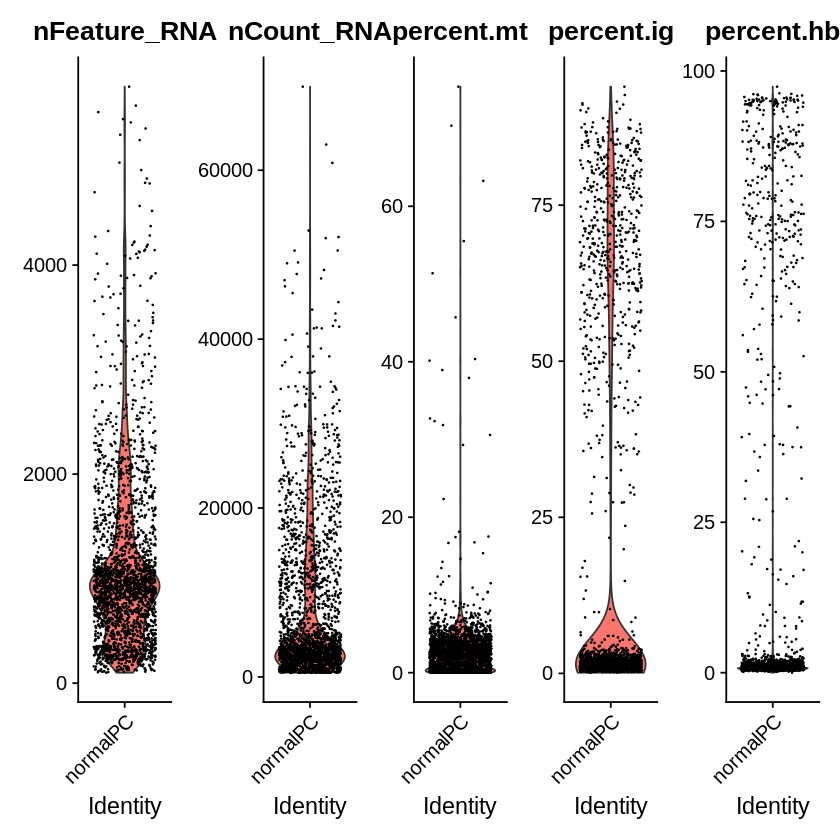

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [8]:
summary(normal@meta.data)

    orig.ident     nCount_RNA     nFeature_RNA      percent.mt     
 normalPC:2368   Min.   :  501   Min.   : 100.0   Min.   : 0.0000  
                 1st Qu.: 2168   1st Qu.: 582.0   1st Qu.: 0.7659  
                 Median : 3588   Median : 922.5   Median : 2.3926  
                 Mean   : 7780   Mean   :1102.2   Mean   : 2.8207  
                 3rd Qu.:11180   3rd Qu.:1331.2   3rd Qu.: 3.7587  
                 Max.   :69894   Max.   :5707.0   Max.   :75.3866  
   percent.ig        percent.hb     
 Min.   : 0.1088   Min.   : 0.0000  
 1st Qu.: 1.0046   1st Qu.: 0.6441  
 Median : 1.6768   Median : 0.8998  
 Mean   :18.2700   Mean   :12.0961  
 3rd Qu.:28.9091   3rd Qu.: 1.5324  
 Max.   :93.9814   Max.   :97.3880  

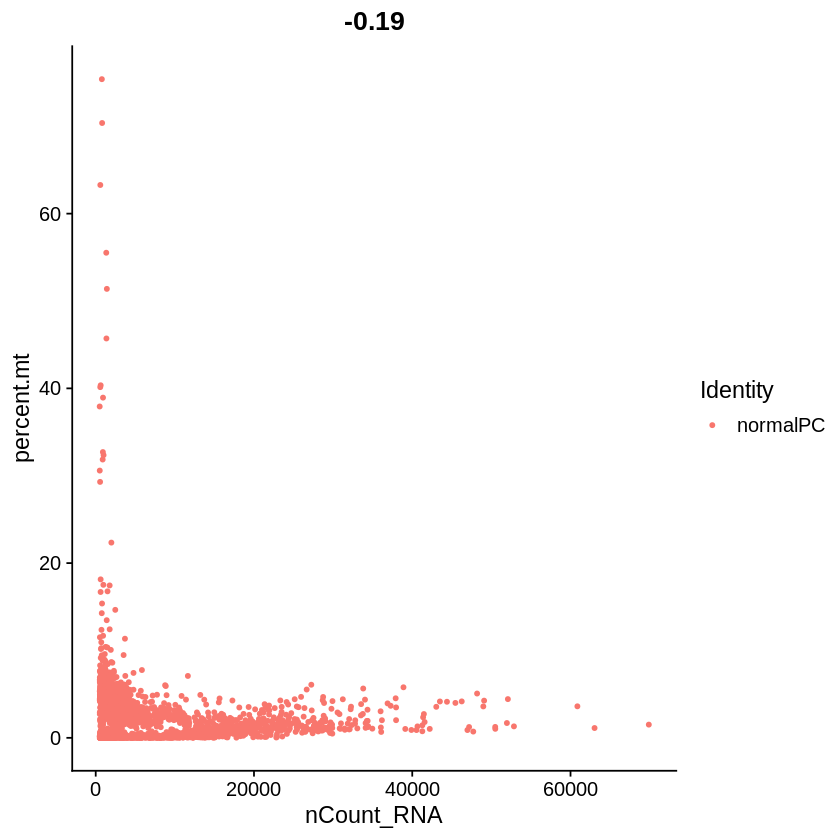

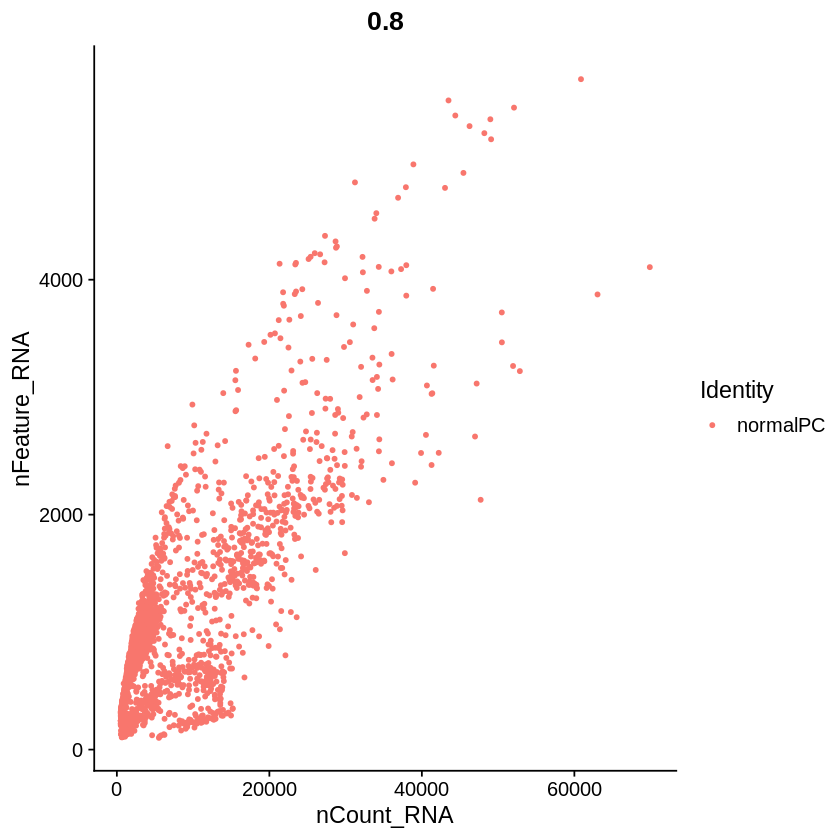

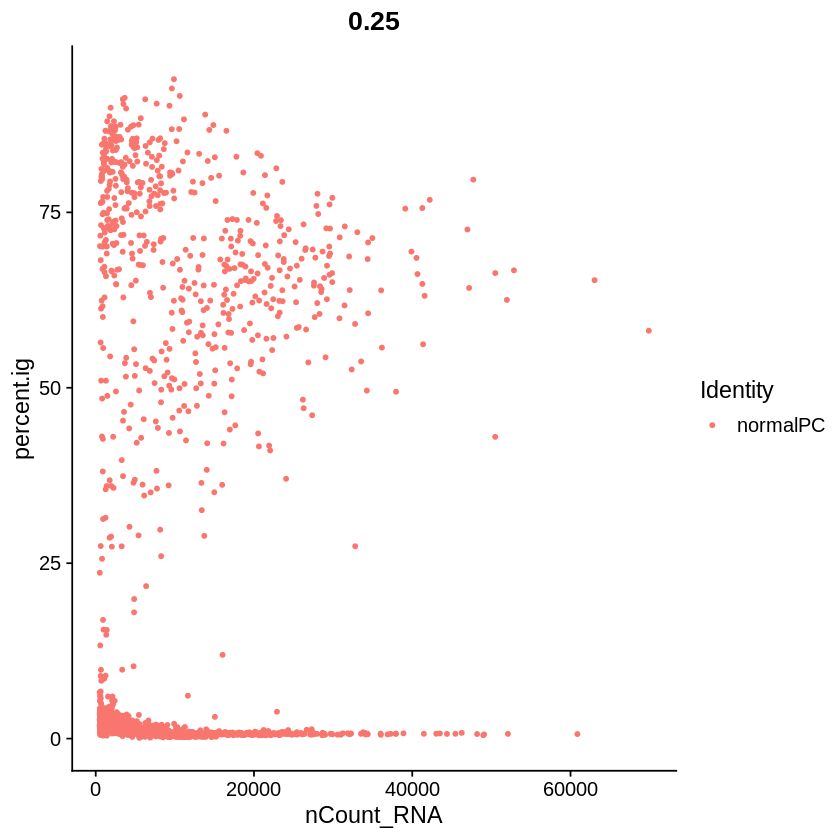

In [9]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [10]:
normal <- subset(normal, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 5 & percent.hb<1)
normal

An object of class Seurat 
15197 features across 1231 samples within 1 assay 
Active assay: RNA (15197 features, 0 variable features)

In [11]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 197 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 197 rows containing missing values (geom_point).”


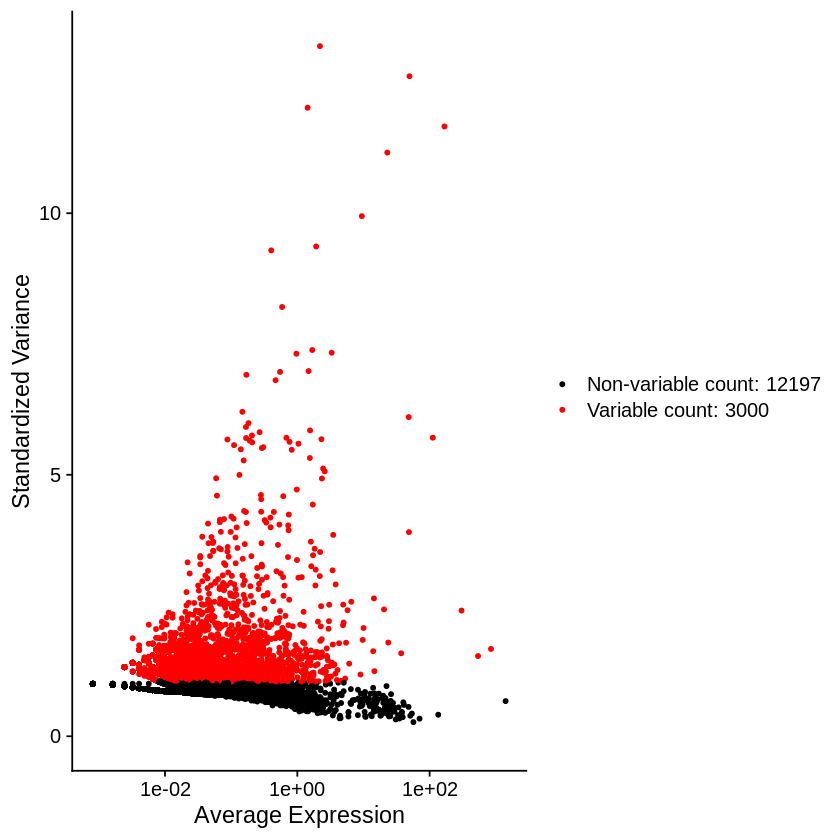

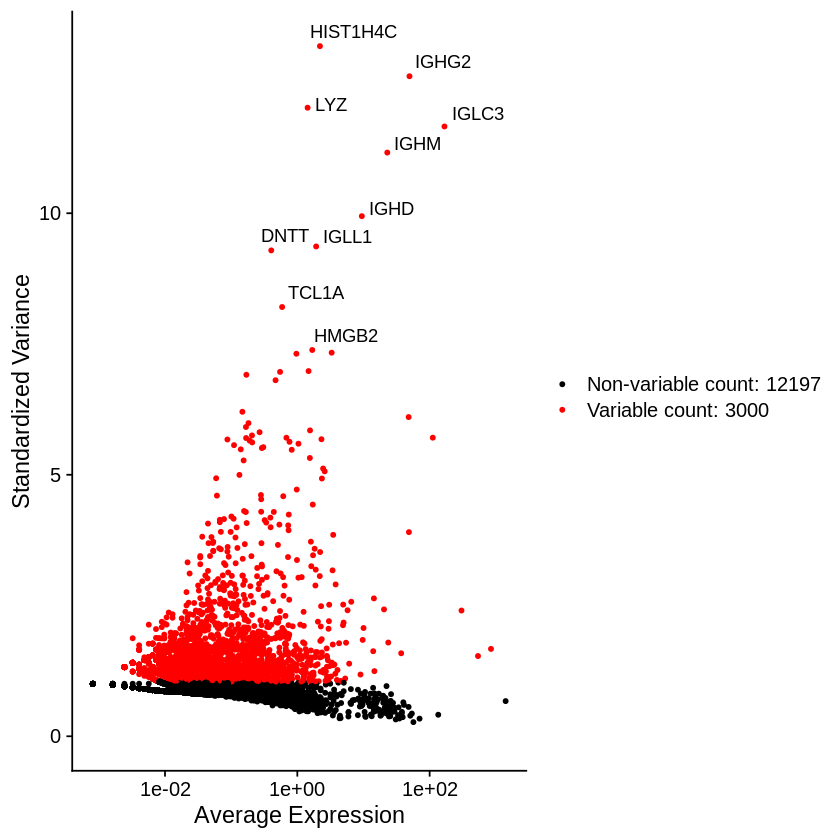

In [12]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [13]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [14]:
length(VariableFeatures(object = normal))

[1] 3000

In [15]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  FKBP11, SSR4, DERL3, SEC11C, DNAJB9, TNFRSF17, HERPUD1, PRDX4, IGHA1, JSRP1 
	   MZB1, SDC1, SELM, IGHG3, HSP90B1, CD27, IGLC2, JCHAIN, FKBP2, MANF 
	   FCRL5, AL928768.3, TXNDC5, VIMP, IGHG4, ERLEC1, PLPP5, SPAG4, SDF2L1, TNFRSF13B 
Negative:  TYMS, KIAA0101, STMN1, IGLL1, SOX4, MKI67, NUSAP1, PTMA, UHRF1, HIST1H4C 
	   H3F3A, HMGB2, TOP2A, CDK1, HMGB1, H2AFY, CENPF, HMGN2, AURKB, VPREB1 
	   TUBB, CDT1, ZWINT, UBE2C, HMGB3, GAPDH, HNRNPA1, CDKN3, TUBA1B, BIRC5 
PC_ 2 
Positive:  TMSB4X, IL32, S100A4, ACTB, TRAC, CCL5, CD2, S100A10, FYB, NKG7 
	   TRBC2, GZMA, CD7, CST7, ANXA1, CD3G, ID2, GZMM, TRBC1, GZMH 
	   ARPC1B, CD247, FLNA, PRF1, LAT, CCL4, CTSW, AC092580.4, LTB, KLRD1 
Negative:  MZB1, ITM2C, DERL3, PRDX4, SEC11C, HSP90B1, HERPUD1, UBE2J1, SSR4, TNFRSF17 
	   JSRP1, FKBP11, DNAJB9, TXNDC5, FKBP2, SDC1, XBP1, SPCS2, GNG7, SSR3 
	   ERLEC1, MANF, TNFRSF13B, POU2AF1, PDIA6, VIMP, FCRL5, JCHAIN, CD79A, NUCB2 
PC_ 3 
Positive:  IL32, TRAC, TRBC2, CD2, IL7R, CD3G,

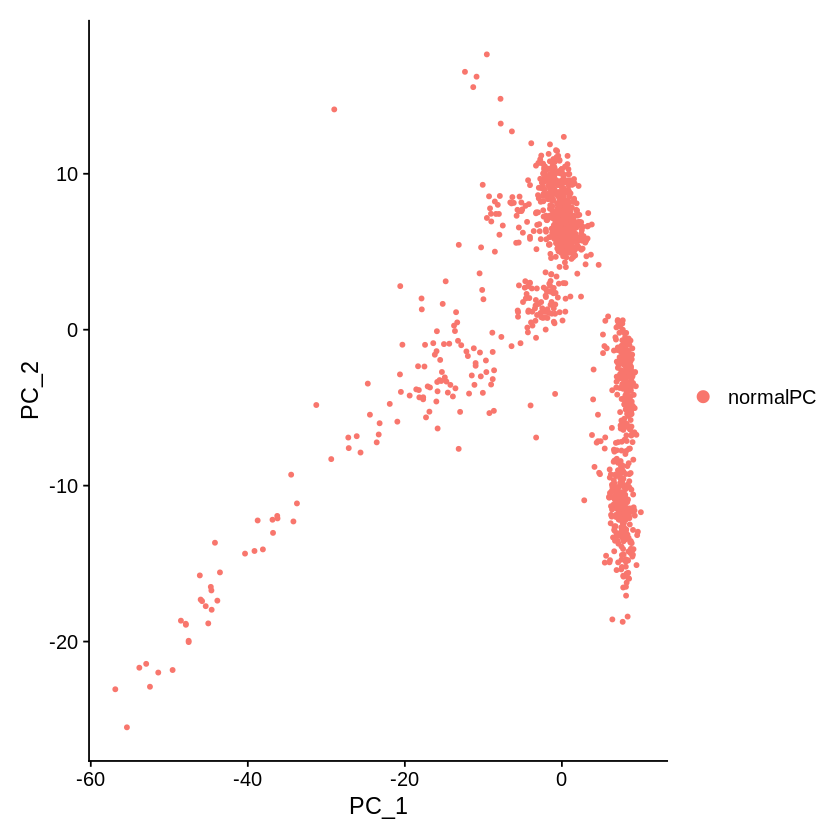

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42865 rows containing missing values (geom_point).”


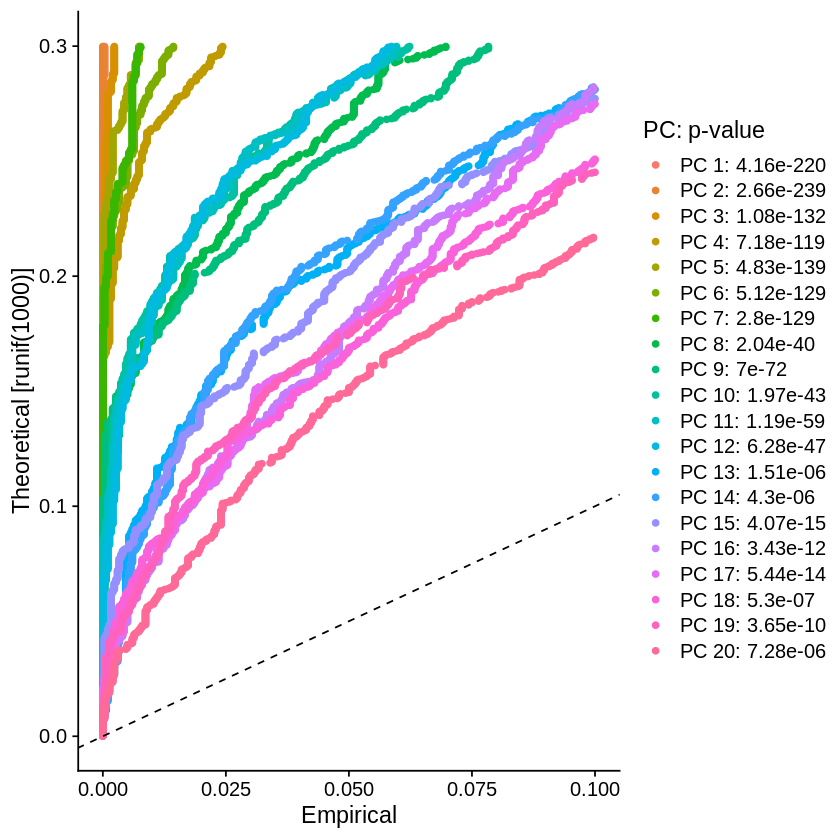

In [18]:
JackStrawPlot(normal, dims = 1:20)

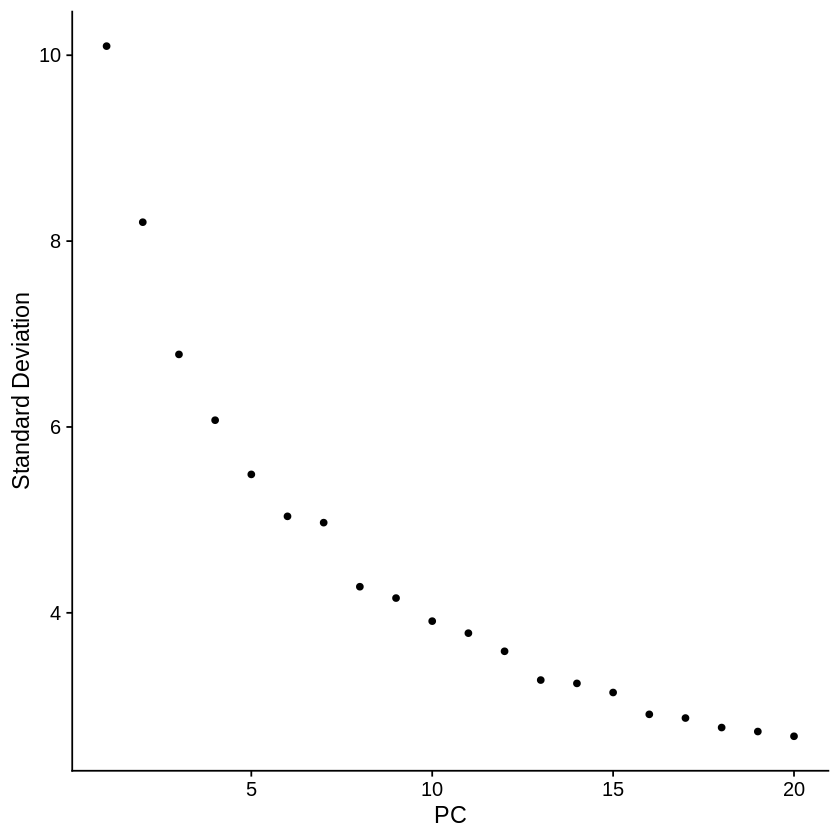

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:21:01 UMAP embedding parameters a = 0.9922 b = 1.112

20:21:01 Read 1231 rows and found 10 numeric columns

20:21:01 Using Annoy for neighbor search, n_neighbors = 30

20:21:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:21:01 Writing NN index file to temp file /tmp/Rtmp4xEbhC/filea55251763ba75

20:21:01 Searching Annoy index using 1 thread, search_k = 3000

20:21:02 Annoy recall = 100%

20:21:02 Commencing smooth kNN distance calibration using 1 thread

20:21:02 Initializing fr

In [21]:
options(repr.plot.height=8,repr.plot.width=8)

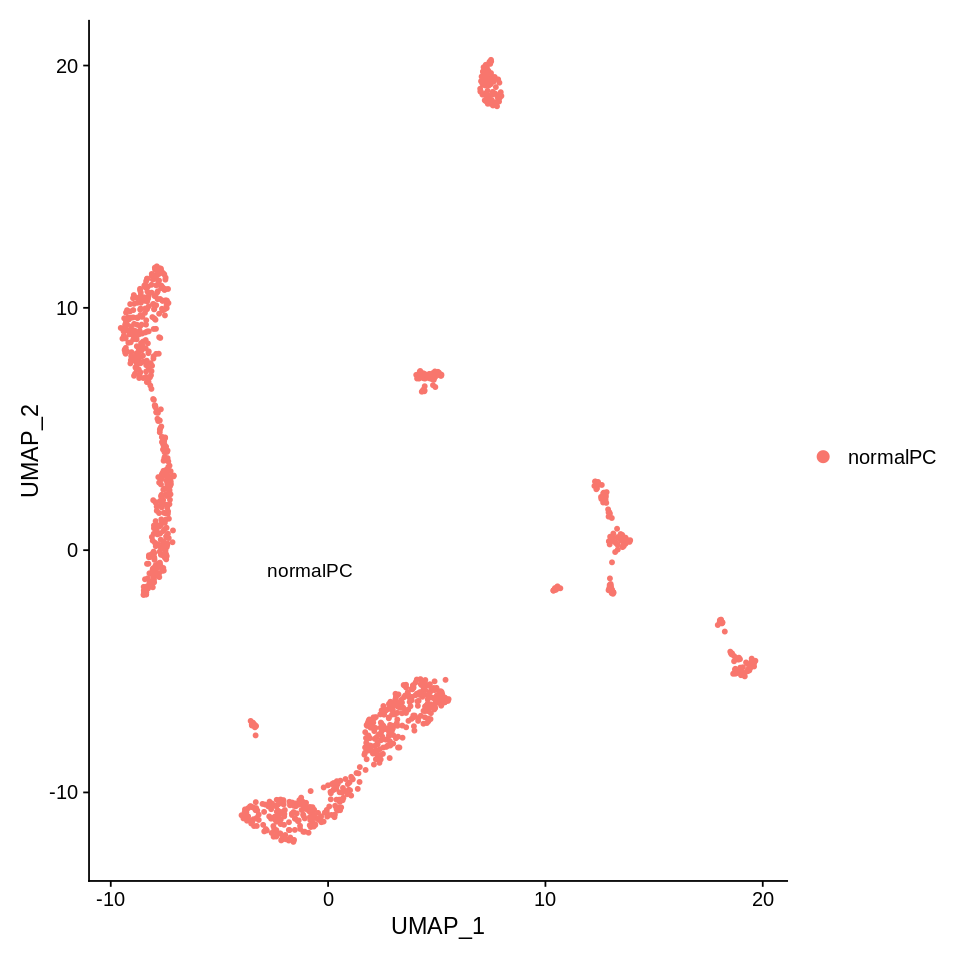

In [22]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


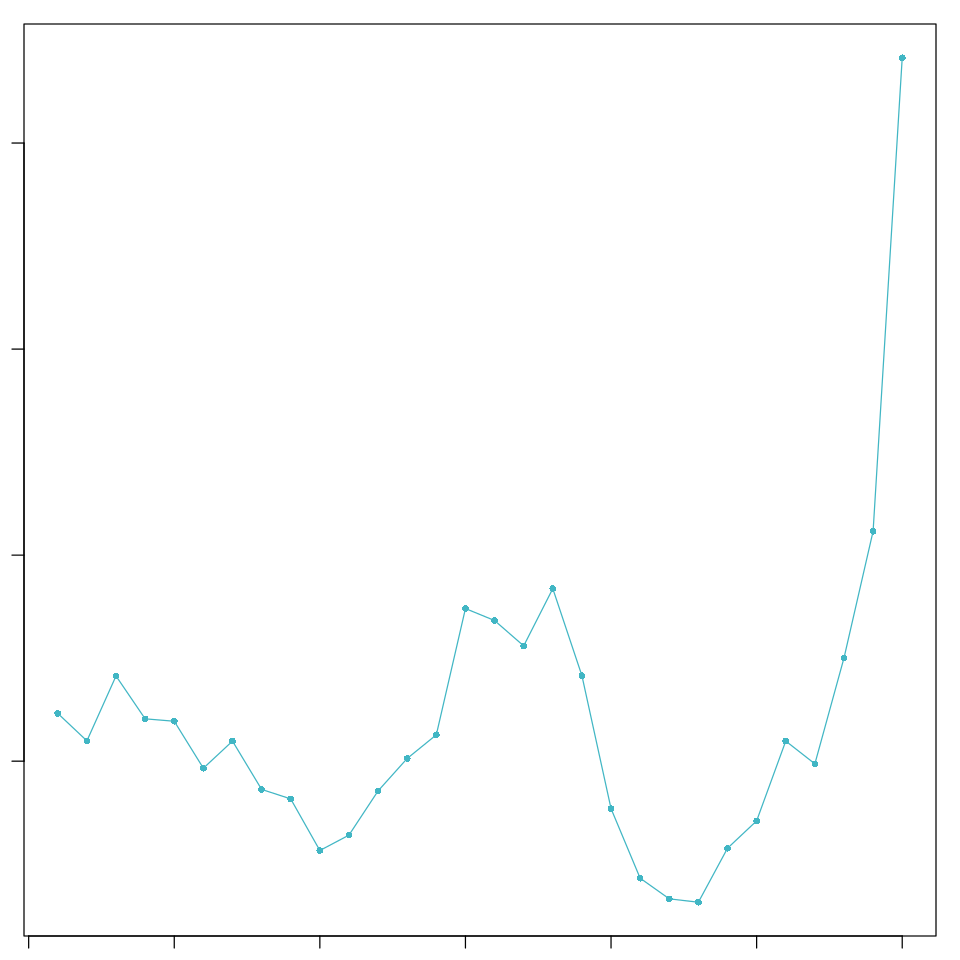

In [23]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:10, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [24]:
normal <- doubletFinder_v3(normal, PCs = 1:10, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 410 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [25]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

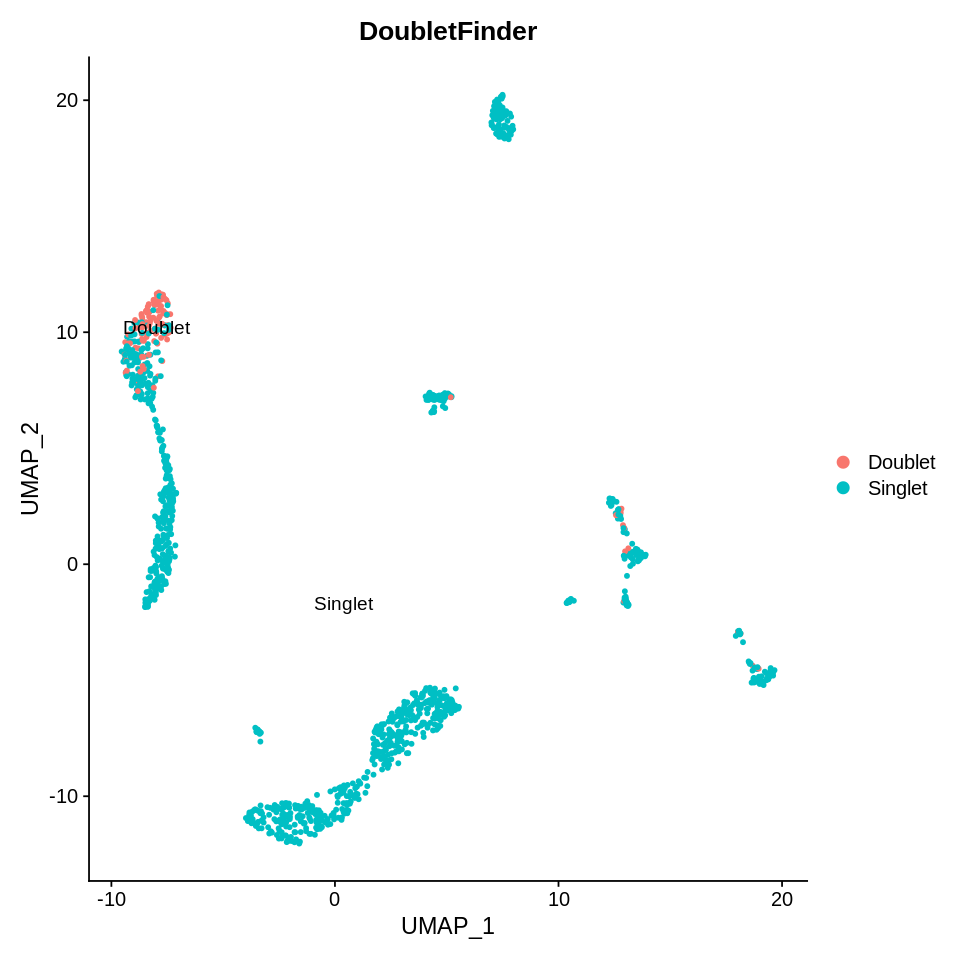

In [26]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [27]:
ggsave('fig.S1.1.pdf',width=8,height=8)
dev.off()

null device 
          1

In [28]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [29]:
normal
normal2

An object of class Seurat 
15197 features across 1231 samples within 1 assay 
Active assay: RNA (15197 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
15197 features across 1108 samples within 1 assay 
Active assay: RNA (15197 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 298 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 298 rows containing missing values (geom_point).”


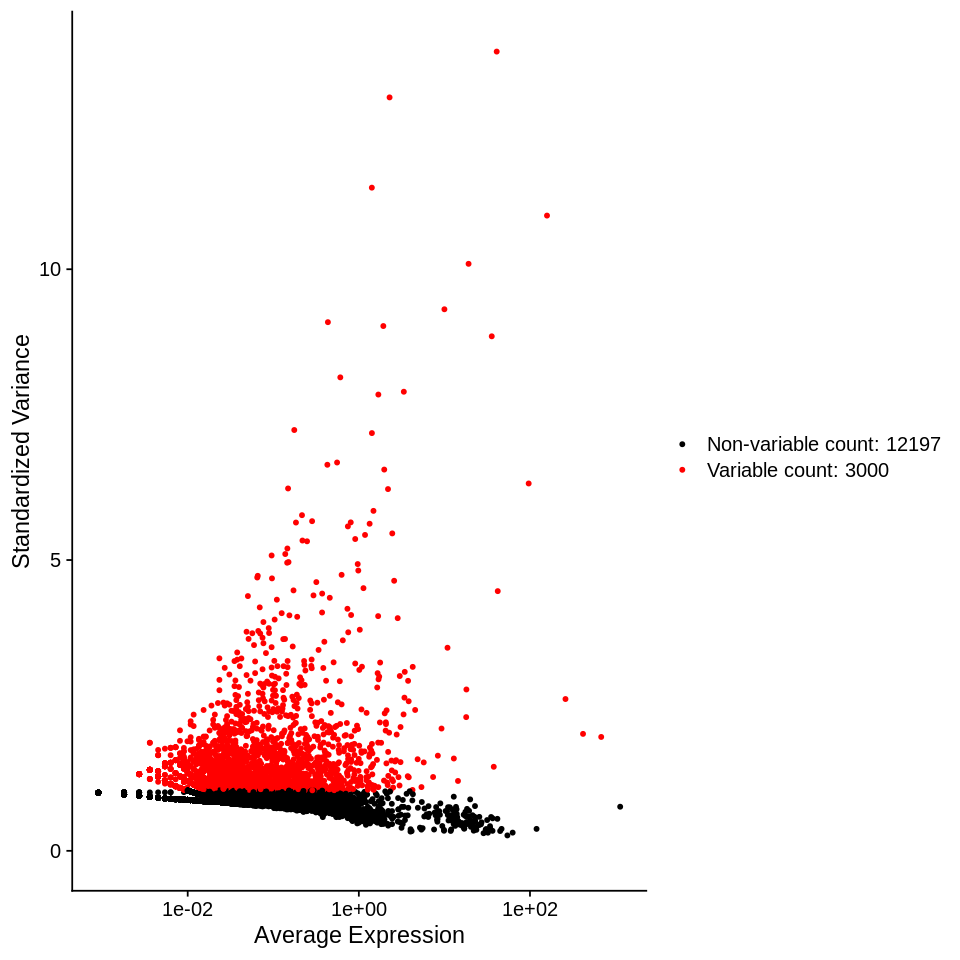

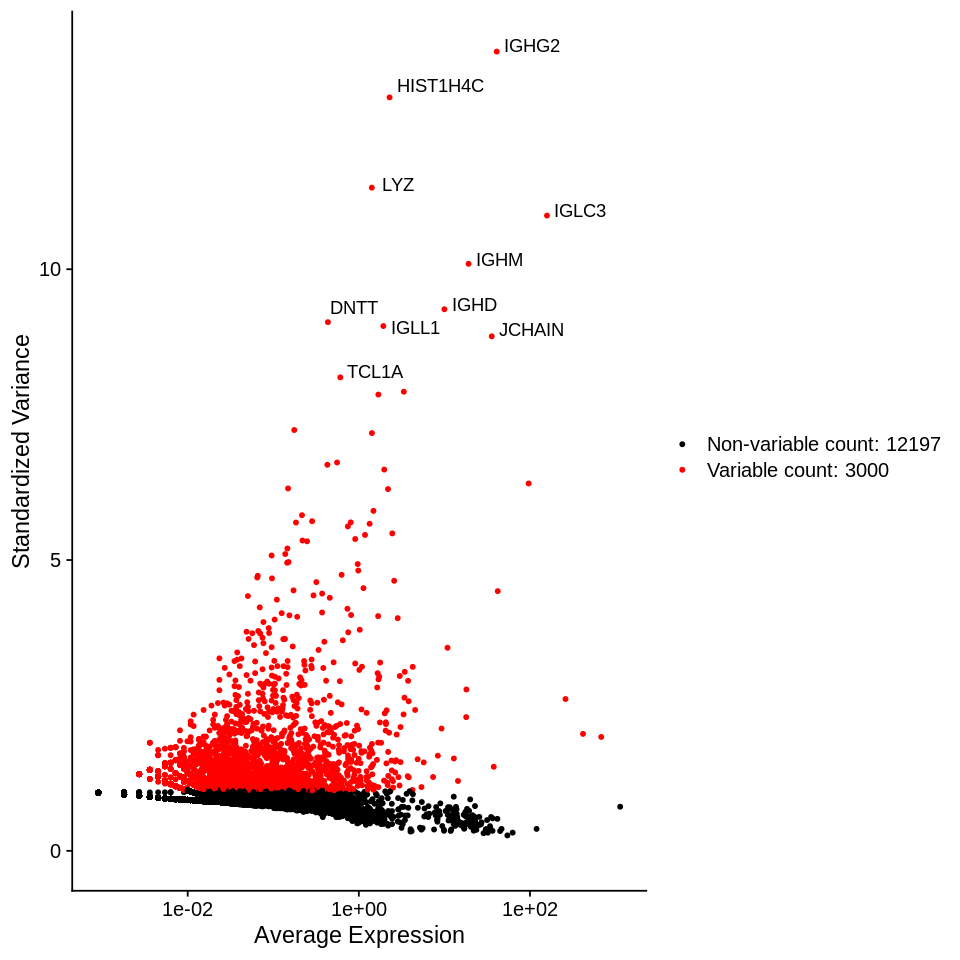

In [30]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [31]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [32]:
length(VariableFeatures(object = normal2))

[1] 3000

In [33]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  TYMS, IGLL1, KIAA0101, NUSAP1, MKI67, STMN1, SOX4, UHRF1, CDK1, TOP2A 
	   HIST1H4C, AURKB, CENPF, HMGB2, PTMA, VPREB1, UBE2C, H3F3A, HMGB3, CDT1 
	   CDKN3, SPC25, SMC4, ZWINT, RRM2, HMGB1, H2AFY, UBE2T, HMGN2, TUBB 
Negative:  FKBP11, SSR4, SEC11C, DERL3, DNAJB9, TNFRSF17, IGHA1, PRDX4, HERPUD1, JSRP1 
	   IGHG3, SDC1, SELM, CD27, IGLC2, MZB1, IGHG4, AL928768.3, JCHAIN, HSP90B1 
	   FKBP2, FCRL5, MANF, TXNDC5, VIMP, SPAG4, SDF2L1, ERLEC1, PLPP5, MYDGF 
PC_ 2 
Positive:  MZB1, DERL3, ITM2C, PRDX4, SEC11C, FKBP11, TNFRSF17, SSR4, JSRP1, DNAJB9 
	   HSP90B1, HERPUD1, SDC1, SPCS2, CD79A, FKBP2, ERLEC1, XBP1, TXNDC5, JCHAIN 
	   FCRL5, UBE2J1, GNG7, NUCB2, IGHA1, SSR3, MANF, TNFRSF13B, IGLC2, POU2AF1 
Negative:  TMSB4X, SH3BGRL3, ACTB, S100A4, IL32, CCL5, S100A10, ARPC1B, FYB, FTH1 
	   ANXA1, NKG7, FLNA, CST7, TRAC, ID2, GZMA, GAPDH, RGS10, RAP1B 
	   COTL1, TAGLN2, GZMM, CD7, H3F3A, GZMH, TYROBP, BIN2, LAT, PRF1 
PC_ 3 
Positive:  IL32, TRAC, TRBC2, CD7, CD3G, GZMM, GZ

In [34]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 43138 rows containing missing values (geom_point).”


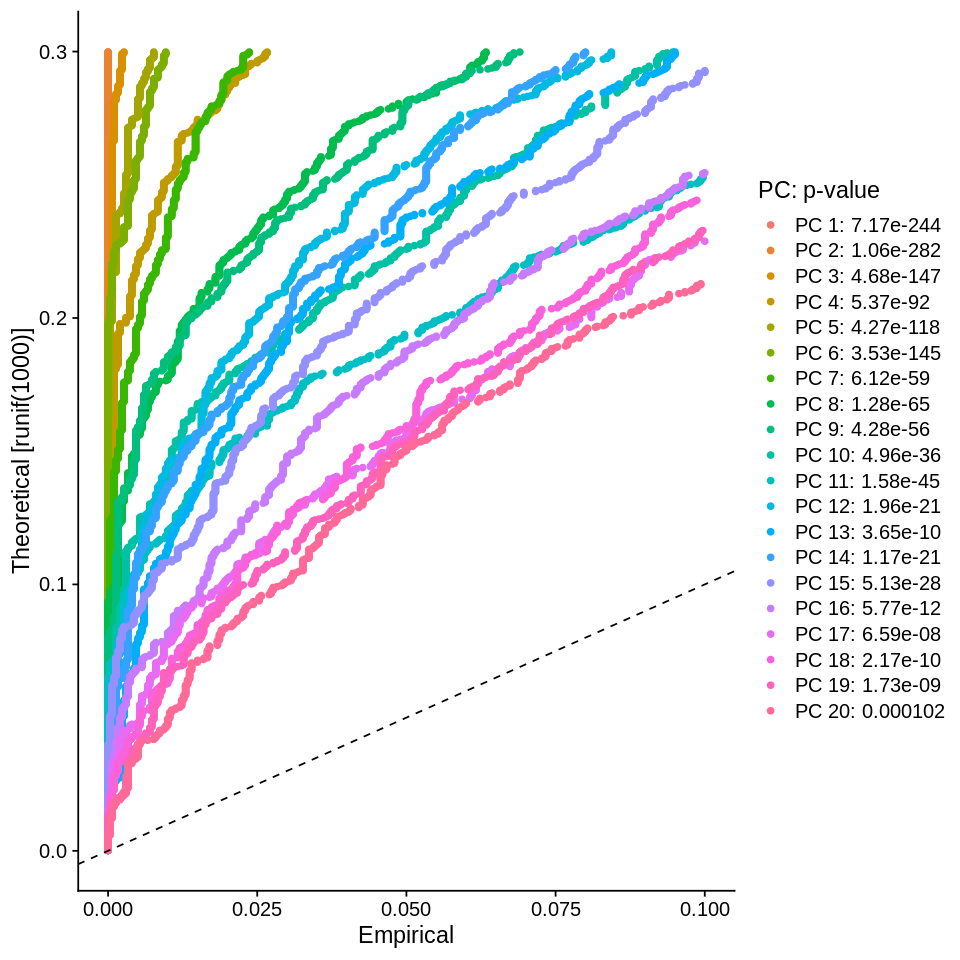

In [35]:
JackStrawPlot(normal2, dims = 1:20)

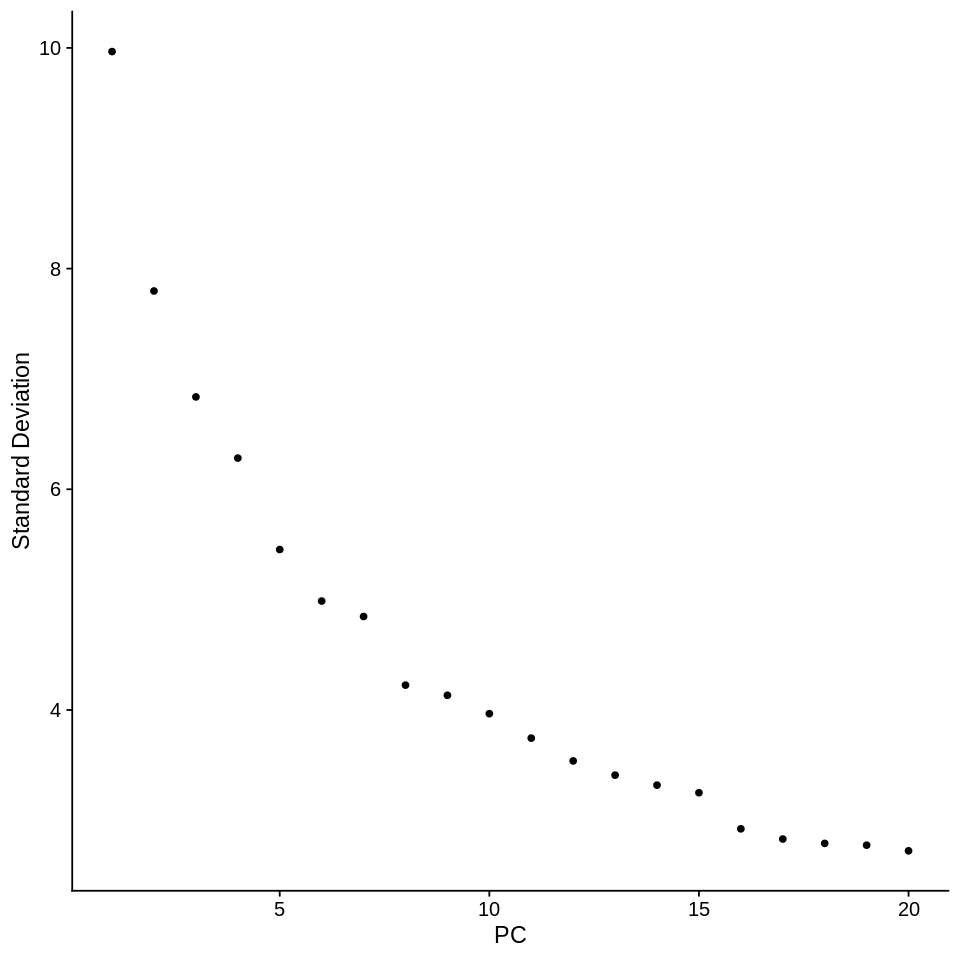

In [36]:
ElbowPlot(normal2)

In [37]:
normal2 <- FindNeighbors(normal2, dims = 1:10)
normal2 <- FindClusters(normal2, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1108
Number of edges: 33973

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8437
Number of communities: 12
Elapsed time: 0 seconds


In [38]:
normal2 <- RunUMAP(normal2, dims = 1:10)

20:23:39 UMAP embedding parameters a = 0.9922 b = 1.112

20:23:39 Read 1108 rows and found 10 numeric columns

20:23:39 Using Annoy for neighbor search, n_neighbors = 30

20:23:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:23:39 Writing NN index file to temp file /tmp/Rtmp4xEbhC/filea5525469fe644

20:23:39 Searching Annoy index using 1 thread, search_k = 3000

20:23:39 Annoy recall = 100%

20:23:39 Commencing smooth kNN distance calibration using 1 thread

20:23:40 Initializing from normalized Laplacian + noise

20:23:40 Commencing optimization for 500 epochs, with 41902 positive edges

20:23:41 Optimization finished



In [39]:
options(repr.plot.height=8,repr.plot.width=8)

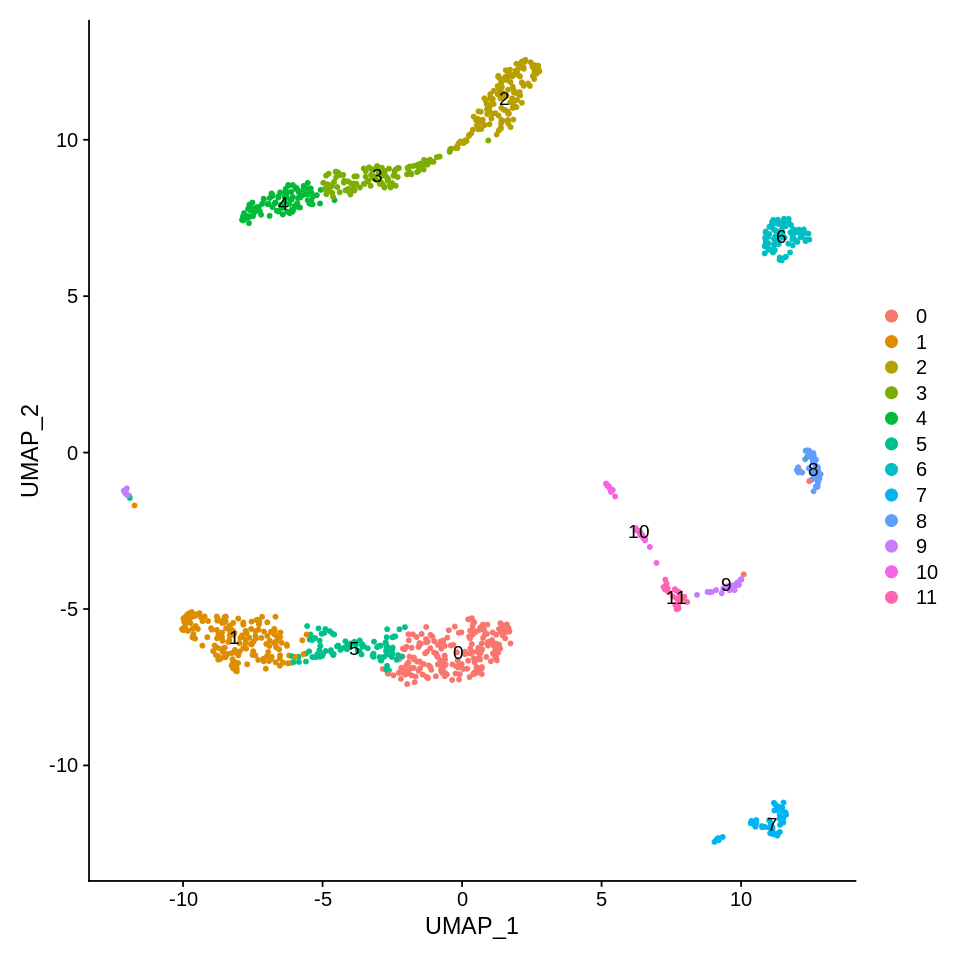

In [40]:
DimPlot(normal2, reduction = "umap",label=T)

In [41]:
ggsave('fig.S1.2.pdf',width=8,height=8)
dev.off()

null device 
          1

In [42]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



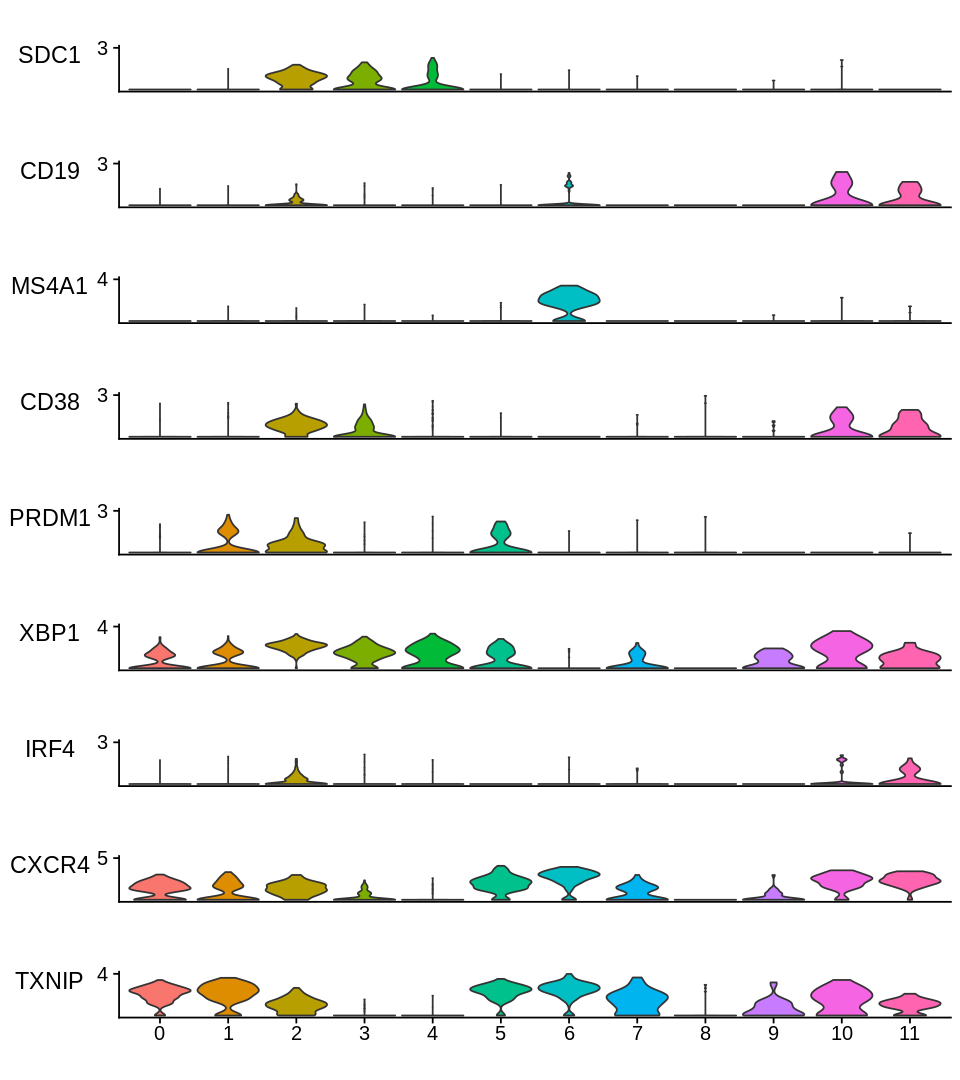

In [45]:
features<- c("SDC1","CD19","MS4A1","CD38","PRDM1","XBP1","IRF4","CXCR4",'TXNIP')
StackedVlnPlot(obj =normal2, features = features)

In [46]:
ggsave('fig.S1.6.pdf',width=8,height=8)
dev.off()

null device 
          1

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



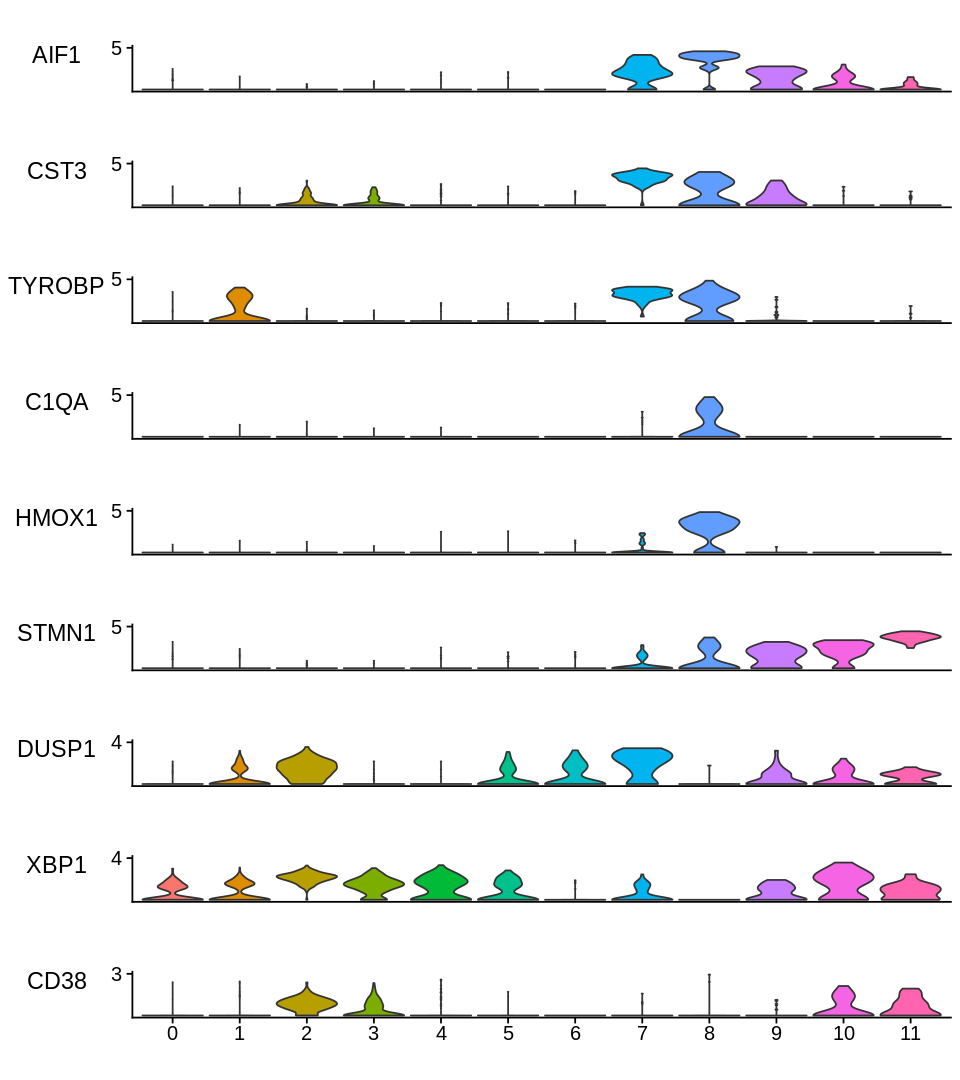

In [47]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [48]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



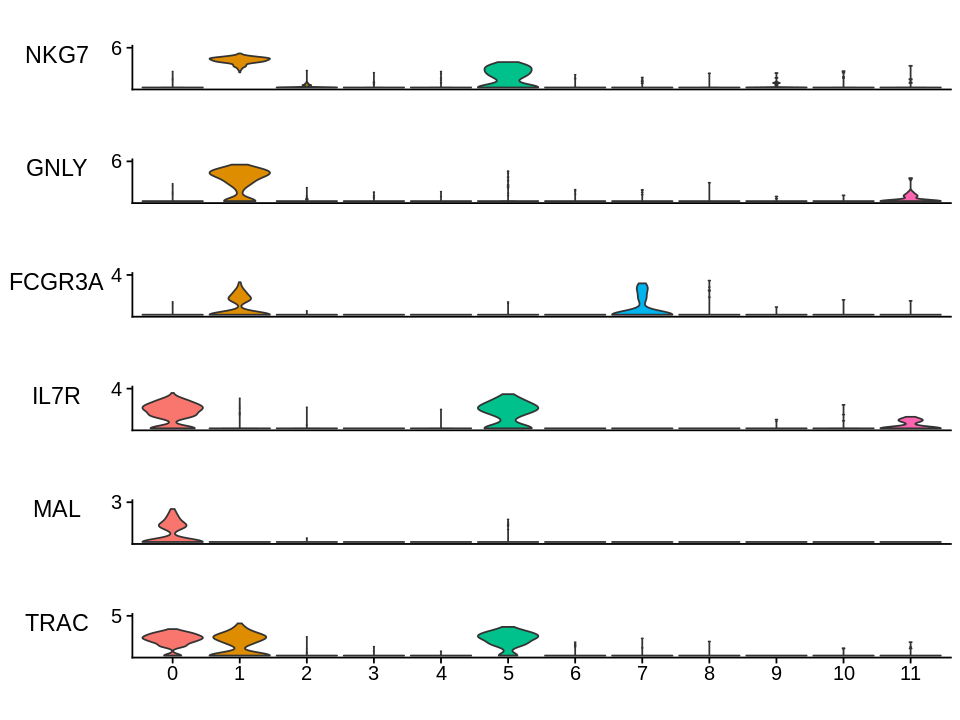

In [49]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



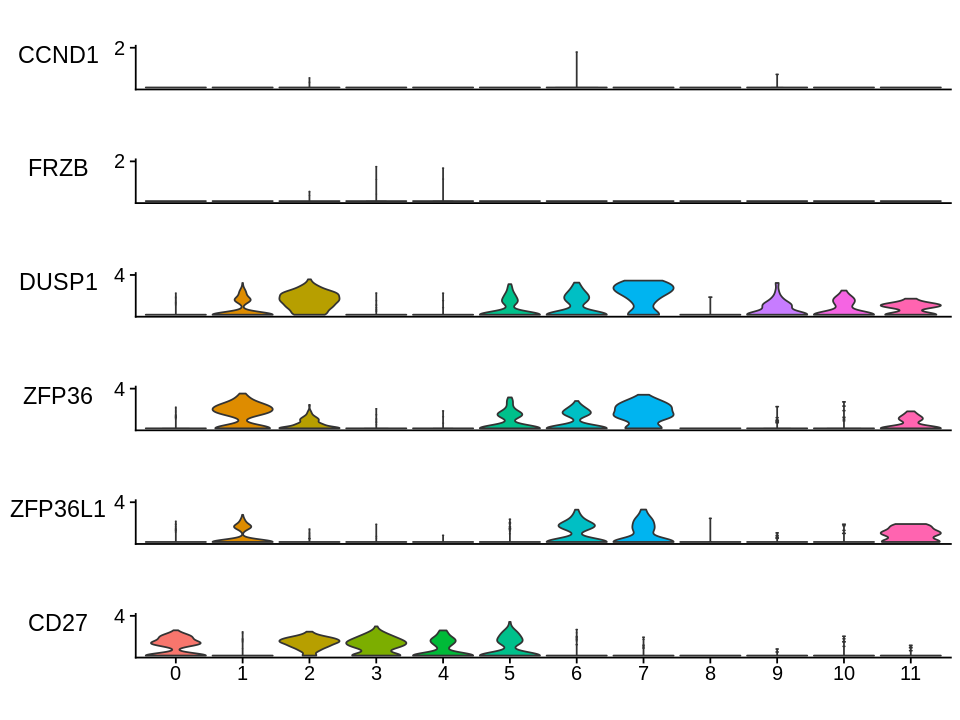

In [50]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [52]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



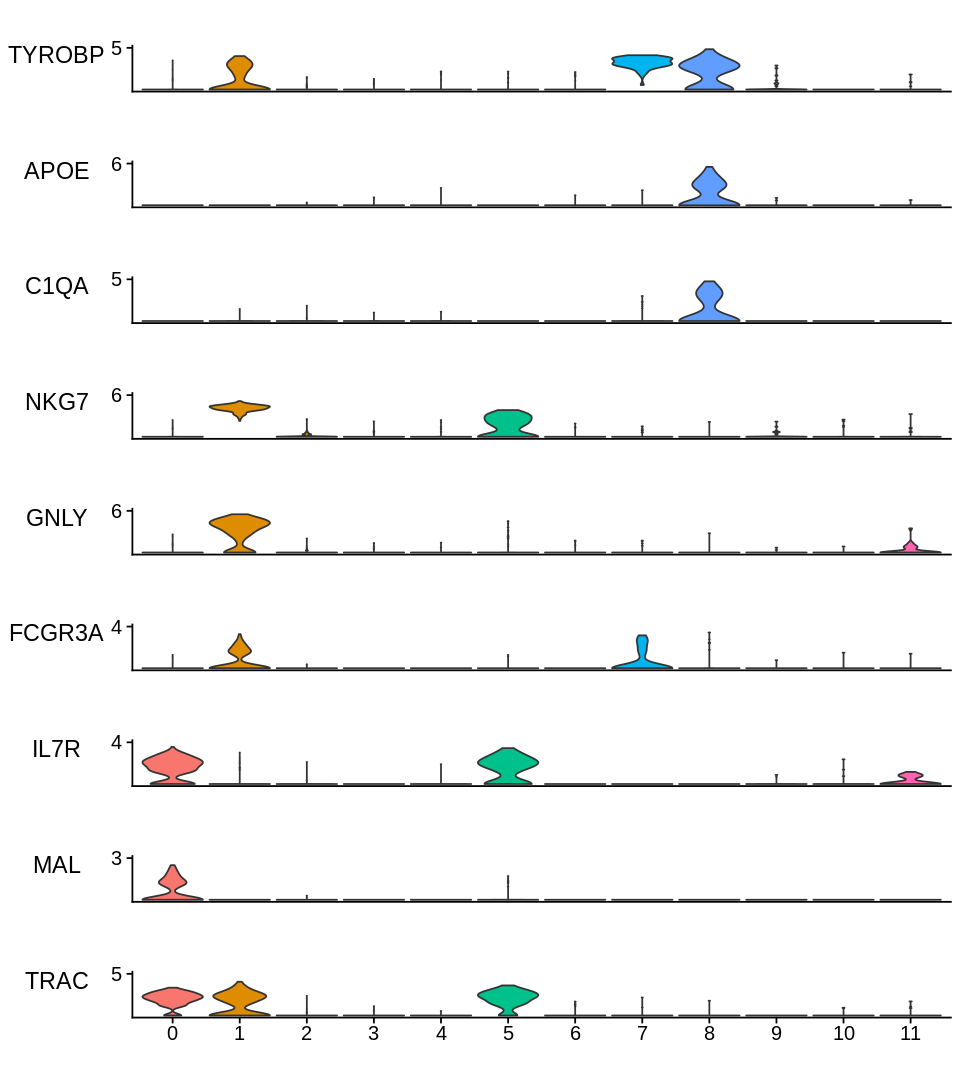

In [53]:
features<- c("TYROBP","APOE","C1QA","NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

In [54]:
ggsave('fig.S1.7.pdf',width=8,height=8)
dev.off()

null device 
          1

In [55]:
options(repr.plot.height=5,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




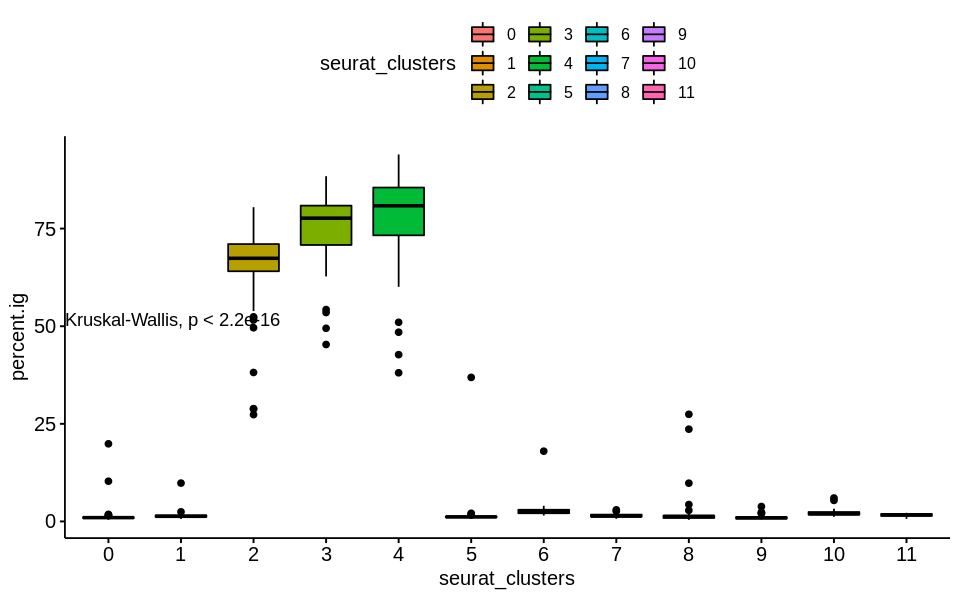

In [56]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [57]:
ggsave('fig.S1.4.pdf',width=8,height=5)
dev.off()

null device 
          1

In [58]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
8.824012e-90,1.915485,0.781,0.119,1.340985e-85,0,IL7R
5.639169e-75,1.425298,0.481,0.031,8.569845e-71,0,CCR7
1.245956e-74,1.704962,0.948,0.414,1.893479e-70,0,LDHB
3.047469e-73,1.727310,0.948,0.301,4.631239e-69,0,LTB
6.153318e-68,1.421729,0.914,0.245,9.351198e-64,0,TRAC
8.715037e-161,3.641366,0.876,0.049,1.324424e-156,1,GZMH
3.397376e-145,4.939691,1.000,0.178,5.162993e-141,1,NKG7
7.286143e-145,3.630753,0.847,0.059,1.107275e-140,1,CCL4
1.794927e-126,3.589930,0.740,0.047,2.727750e-122,1,GZMB


In [59]:
options(repr.plot.height=10,repr.plot.width=10)

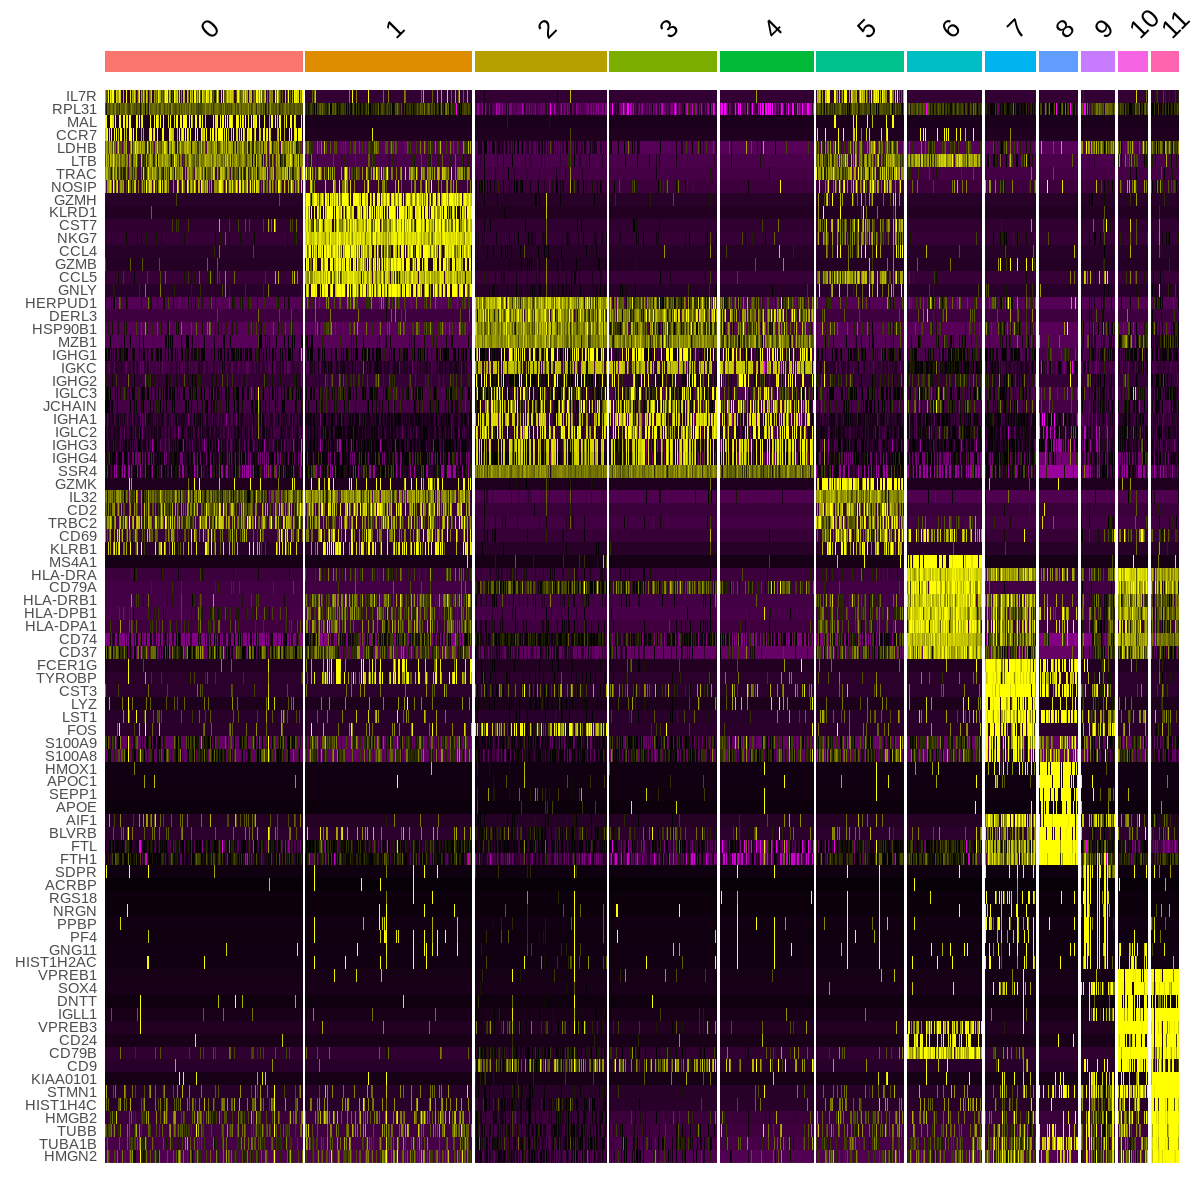

In [60]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [61]:
ggsave('fig.S1.3.pdf',width=8,height=8)
dev.off()

null device 
          1

In [51]:
library("Seurat")
library("SingleR")

Warning message:
“multiple methods tables found for ‘which’”
Warning message:
“multiple methods tables found for ‘which’”


In [52]:
counts<-normal2@assays$RNA@counts
clusters<-normal2@meta.data$seurat_clusters
ann=normal2@meta.data$orig.ident

In [53]:
singler = CreateSinglerObject(counts, annot = ann, "normal",
  species = "Human", citation = "",
  ref.list = list(), variable.genes = "de",
  fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
  reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 15197x1108"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3197"
[1] "Number of cells: 1108"
[1] "Number of DE genes:3197"
[1] "Number of clusters: 12"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:2507"
[1] "Number of cells: 1108"
[1] "Number of DE genes:2507"
[1] "Number of clusters: 12"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3084"
[1] "Number of cells: 1108"
[1] "Number of DE genes:3084"
[1] "Number of clusters: 12"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:2531"
[1] "Number of cells: 1108"
[1] "Number of DE genes:2531"
[1] "Number of clusters: 12"


In [54]:
singler$seurat = normal
singler$meta.data$xy = normal2@reductions$umap@cell.embeddings
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels
clusterAnn

0,CD4+ T-cells
1,NK cells
2,B-cells
3,B-cells
4,B-cells
5,CD8+ T-cells
6,B-cells
7,Monocytes
8,Macrophages
9,HSC
10,B-cells


In [55]:
clusterAnn<-as.data.frame(clusterAnn)
clusterAnn

,V1
,<chr>
0,CD4+ T-cells
1,NK cells
2,B-cells
3,B-cells
4,B-cells
5,CD8+ T-cells
6,B-cells
7,Monocytes
8,Macrophages


In [56]:
type<-as.data.frame(singler$other)
type

,singler$other
,<chr>
AAACCTGAGGCTATCT-1,CD4 T cells
AAACCTGCAGTGGAGT-1,CD4 T cells
AAACCTGTCAGTCAGT-1,CD8 T cells
AAACGGGCACGAGGTA-1,CD4 T cells
AAACGGGCATCACAAC-1,CD4 T cells
AAAGATGGTCCGAATT-1,CD14+ Monocytes
AAAGCAATCAACGGGA-1,NK cells
AAAGTAGAGCTCCTCT-1,CD8 T cells
AAATGCCGTGCGCTTG-1,CD8 T cells


In [57]:
count<-table(type)
count

type
          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
              281               167               297               161 
  Dendritic cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
               44                35                44                79 

In [58]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [59]:
plasma<-subset(normal2,ident=c(2,3,4))

In [60]:
options(repr.plot.height=8,repr.plot.width=8)

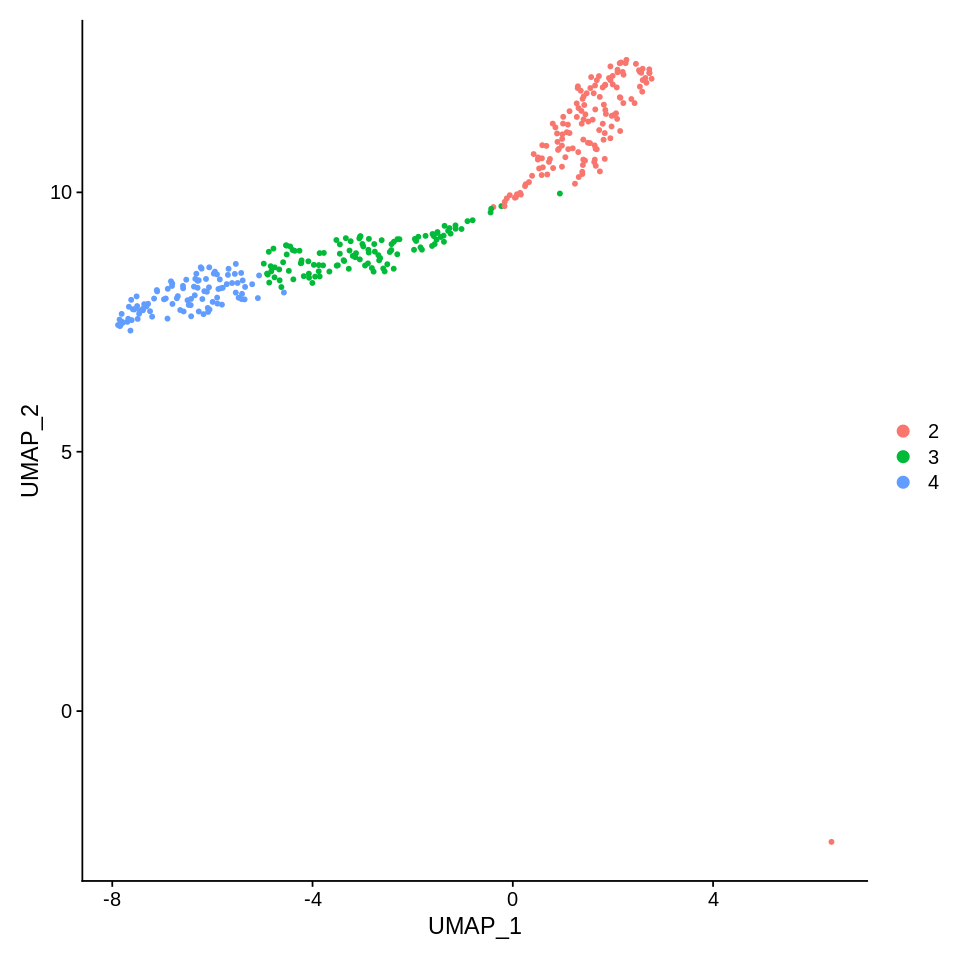

In [61]:
DimPlot(plasma, reduction = "umap")

In [62]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.435824e-60,2.5771061,0.921,0.033,3.701721e-56,2,KLF6
1.413890e-54,2.3584647,0.893,0.056,2.148689e-50,2,DUSP1
1.517162e-54,5.1729542,0.964,0.276,2.305631e-50,2,MALAT1
6.872607e-51,2.6848490,0.979,0.369,1.044430e-46,2,MT-ND4
9.615026e-48,2.3160620,0.979,0.318,1.461196e-43,2,MT-CYB
4.353891e-46,2.4805881,0.986,0.481,6.616608e-42,2,MT-CO2
6.083884e-46,2.2947511,0.979,0.425,9.245678e-42,2,MT-CO1
7.535039e-46,2.2598087,0.971,0.336,1.145100e-41,2,MT-CO3
9.395321e-46,2.3527912,0.971,0.444,1.427807e-41,2,MT-ND3


In [63]:
options(repr.plot.height=8,repr.plot.width=8)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



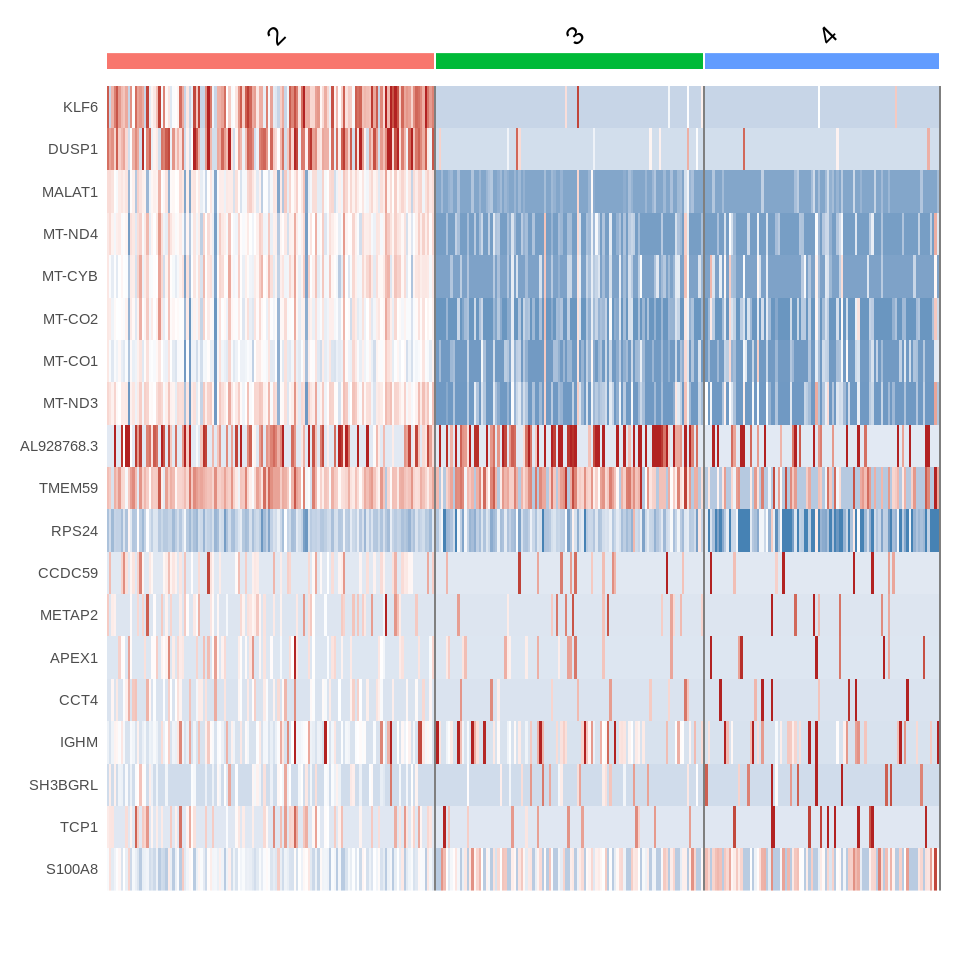

In [64]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [65]:
save(plasma,file="0710-normalPC-plasma.Rda")

In [66]:
plasma

An object of class Seurat 
15197 features across 354 samples within 1 assay 
Active assay: RNA (15197 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [67]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



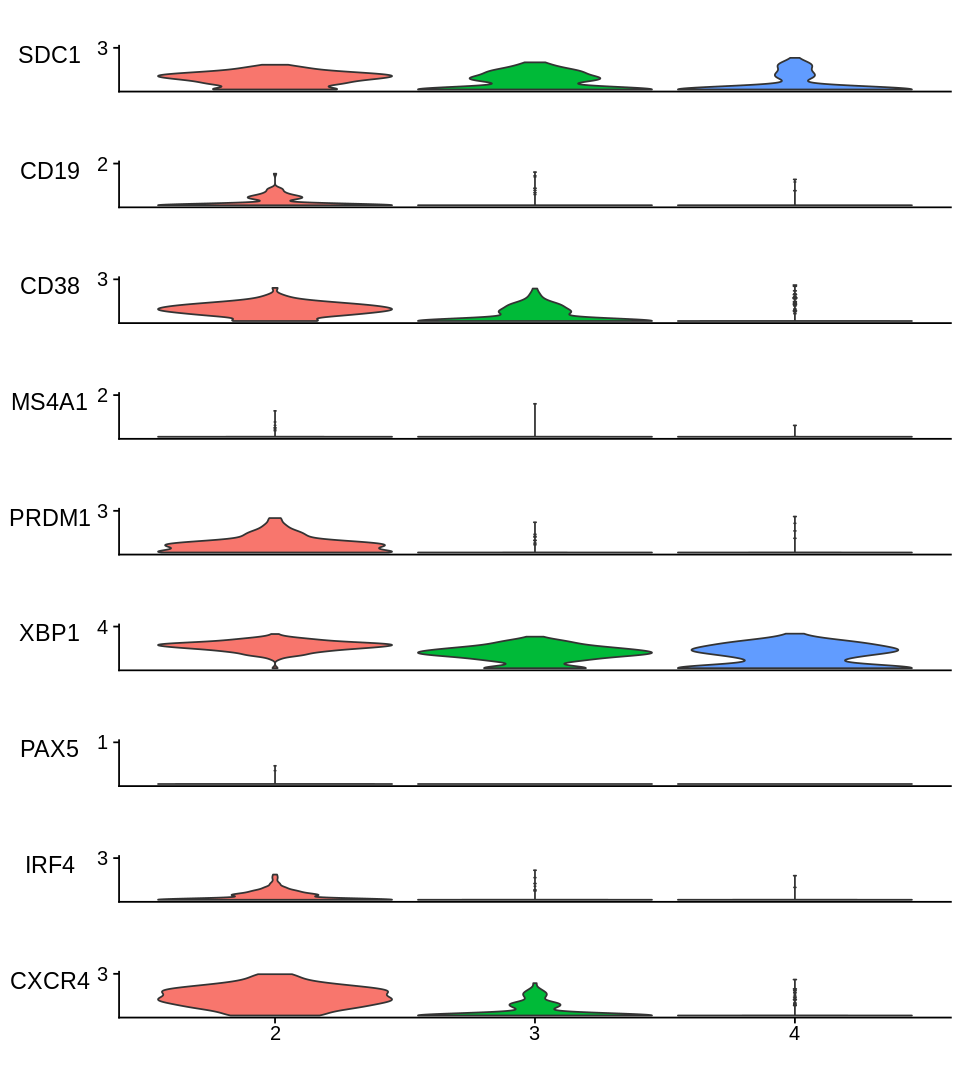

In [68]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



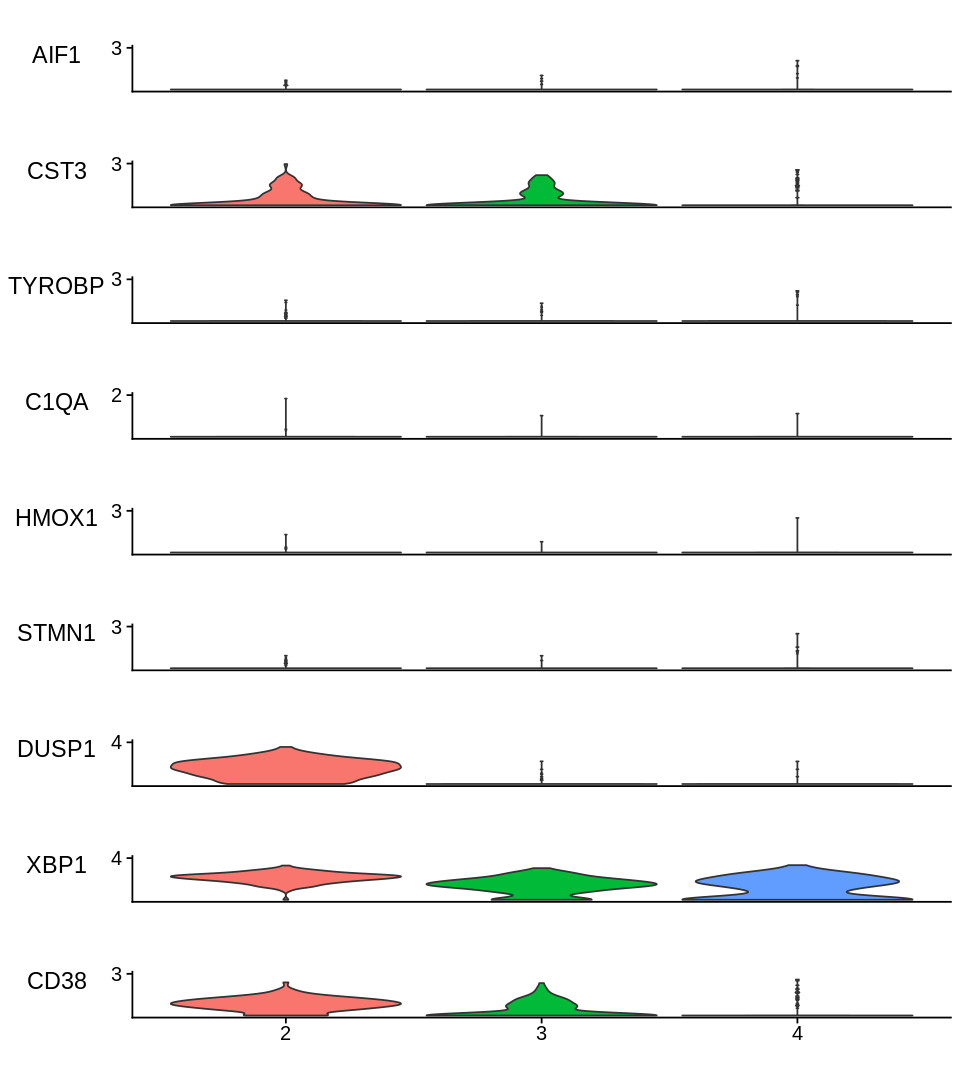

In [69]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [70]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



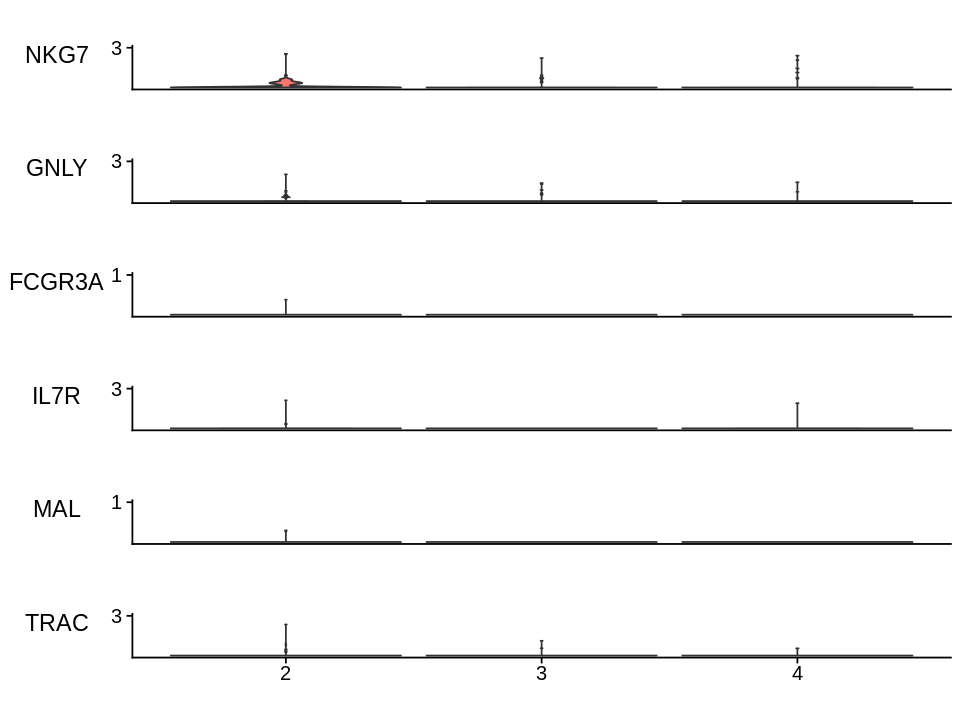

In [71]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



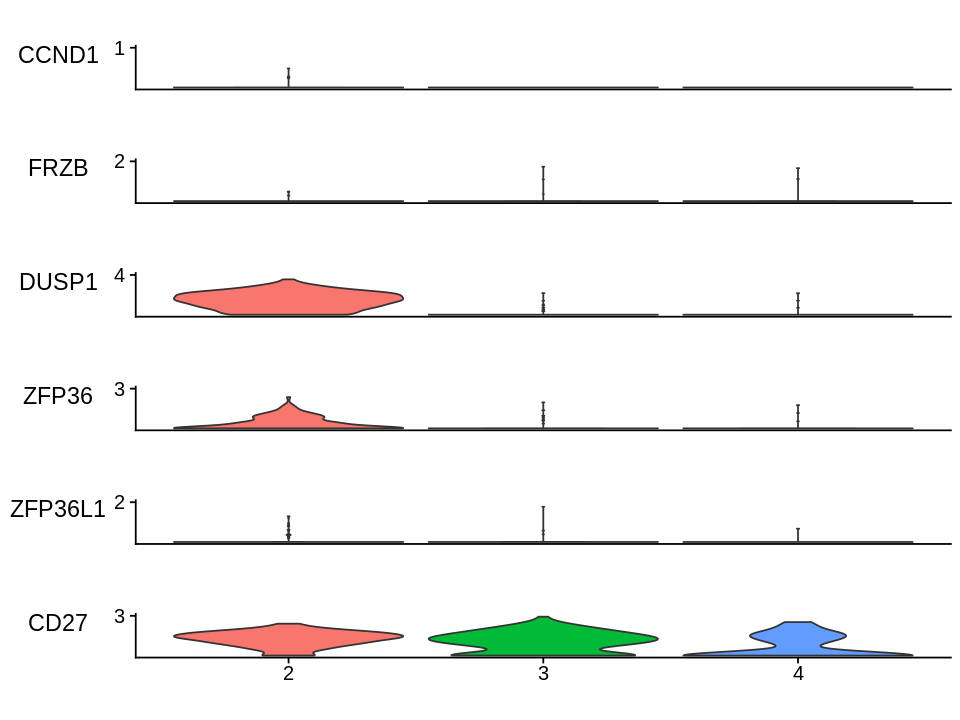

In [72]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =plasma, features = features)